# Exploratory analysis

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import numpy as np
import pandas as pd
import seaborn as sns


import plotly.express as px

In [3]:
import sys
sys.path.append('../')

from EnefitModels.src.features import load_data

data = load_data.load_processed_data('../data')

## Questions and Ideas while working:

1. What are the time zones of the different datasets? The weather forecasts explicitly specify a timezone.
2. Outliers in electricity prices: there are some extreme spikes.


### Initial set of regressors
- gas and electricity prices
- eic and installed capacity for points in the client set.

### Explaination for the missing data points in the electricity markets
Are these DST transitions?


## Price data

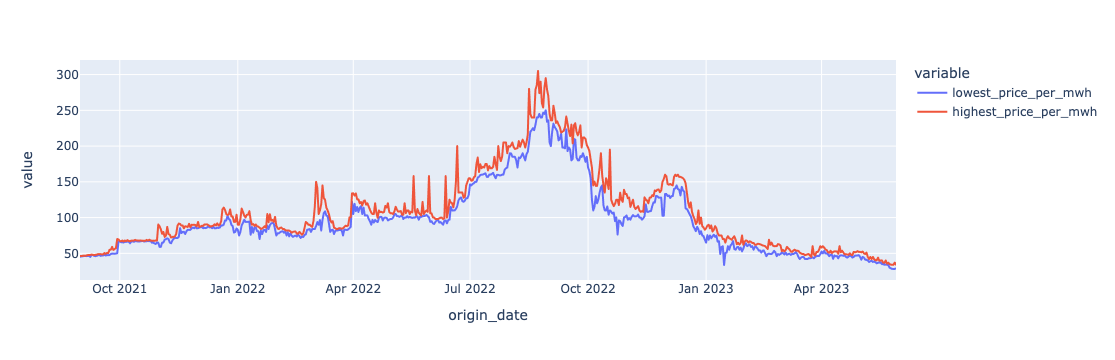

In [4]:
px.line(data.gasPrices, x='origin_date', y=['lowest_price_per_mwh', 'highest_price_per_mwh'])

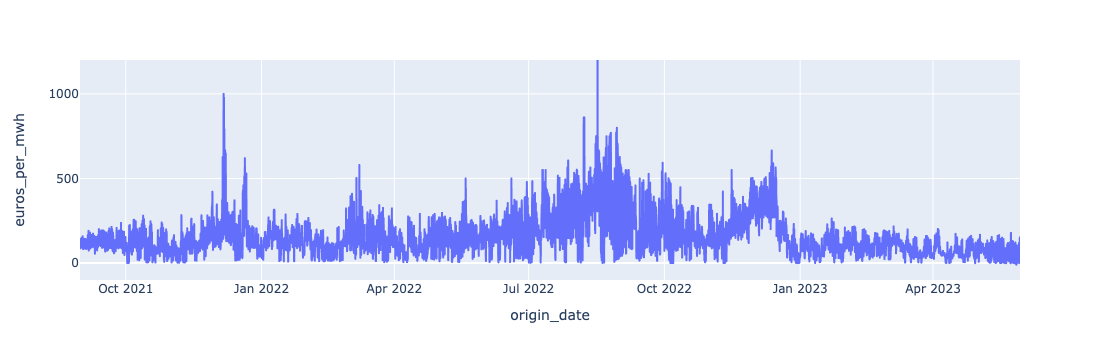

In [6]:
fig = px.line(data.electricityPrices, x='origin_date', y='euros_per_mwh')
fig.update_yaxes(range=[-100, 1200])
fig.show()

<AxesSubplot:title={'center':'Daily electricity prices: mean std dev'}, xlabel='origin_hour', ylabel='euros_per_mwh'>

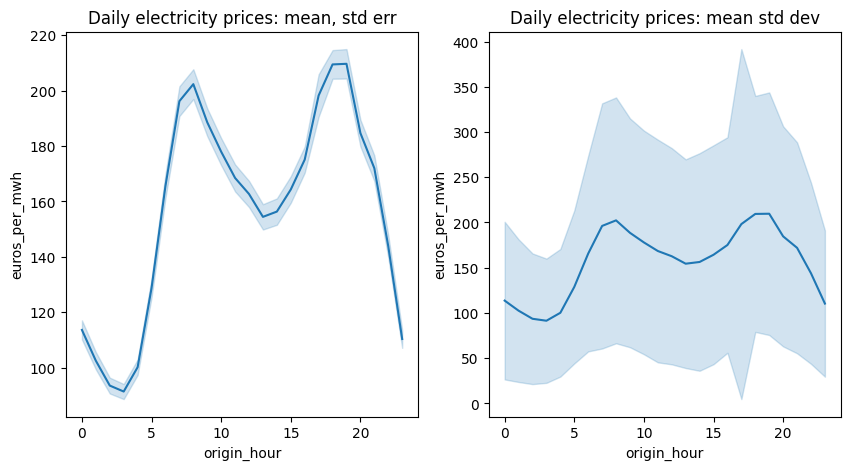

In [8]:
hours = data.electricityPrices.origin_date.dt.hour
hours.name = 'origin_hour'

figsize(10, 5)
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.title('Daily electricity prices: mean, std err')
sns.lineplot(data=pd.concat([data.electricityPrices, hours],axis=1), x='origin_hour', y='euros_per_mwh', errorbar='se')

plt.subplot(1,2,2)
plt.title('Daily electricity prices: mean std dev')
sns.lineplot(data=pd.concat([data.electricityPrices, hours],axis=1), x='origin_hour', y='euros_per_mwh', errorbar='sd')



This is the time-dependence of price with time of day. 
1. The dependence looks reasonable
2. The mean effect is well estimated, even though it is swamped by variance from other factors.

A better way to measure this is the daily time dependence around daily average.

In [16]:
gasMean = (data.gasPrices.set_index('origin_date').lowest_price_per_mwh +
           data.gasPrices.set_index('origin_date').highest_price_per_mwh )/2
gasMean.name = 'gasMean'

gasDiff = (data.gasPrices.set_index('origin_date').highest_price_per_mwh -
           data.gasPrices.set_index('origin_date').lowest_price_per_mwh)
gasDiff.name = 'gasRange'

days = data.electricityPrices.origin_date.dt.date
electricData = data.electricityPrices.groupby(days).agg(electricMean=('euros_per_mwh', 'mean'),
                                                       electricRange=('euros_per_mwh', np.ptp) )

priceComp = pd.concat([electricData, gasMean, gasDiff], axis=1)

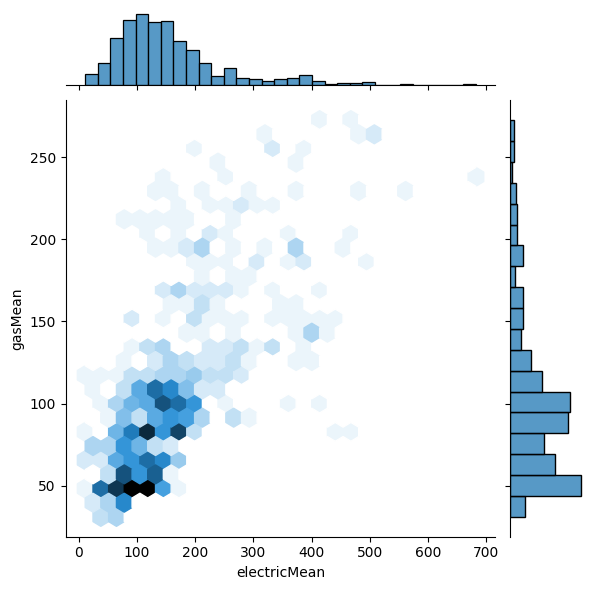

In [54]:
fig = sns.jointplot(data=priceComp, x='electricMean', y='gasMean', kind='hex')
fig.fig.suptitle = 'Daily average electricity and gas prices'

(0.0, 100.0)

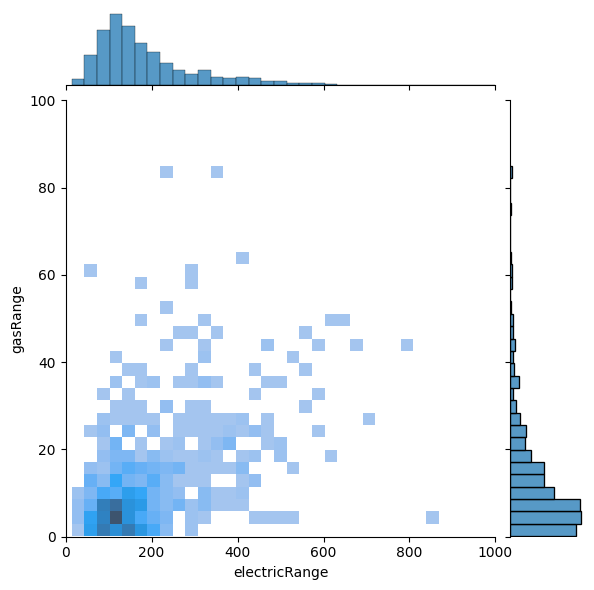

In [52]:
fig = sns.jointplot(data=priceComp, x='electricRange', y='gasRange', kind='hist')
plt.xlim(0, 1000)
plt.ylim(0, 100)

The mean daily prices of electricity and gas are nicely correlated. There is less clear connection between the volatility of gas and electrical prices daily. However, the volatility of electricity is much higher.

## Weather

Honestly, my first question is about the timezones that the dates are given in these dateset. The forecasts are in UTC, but what about the historical weather?

Now that I think about it, the same question also applies to all of the other data sets.
- the missing data-points in the electricity prices seem to align with daylight savings...
- why are there no repeated prices in the electricity pricing?
- why are there no missing datapoints in train, which we know to be in local time?

In [148]:
data.weatherForecast.origin_datetime[0]

Timestamp('2021-09-01 00:00:00+0000', tz='UTC')

In [158]:
data.weatherForecast.forecast_datetime[0]

Timestamp('2021-09-01 01:00:00+0000', tz='UTC')

In [159]:
data.weatherForecast

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 00:00:00+00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 00:00:00+00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 00:00:00+00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 00:00:00+00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0


In [211]:
data.weatherHistorical.duplicated().any()

True

## Clients and Training

In [60]:
data.clients.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

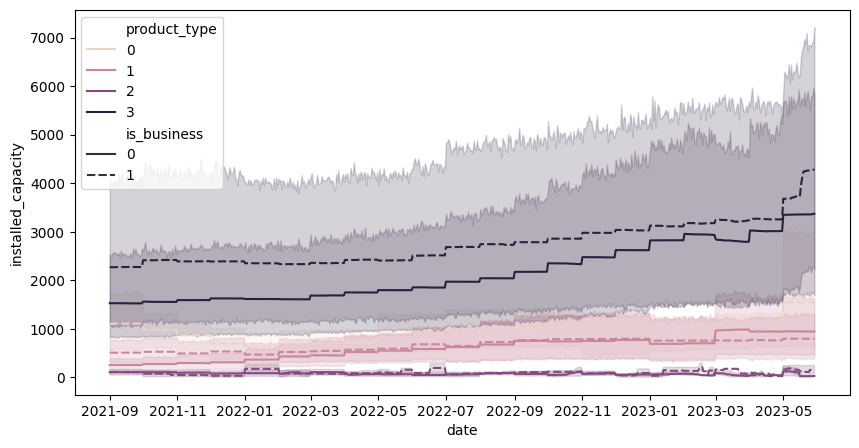

In [71]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='product_type', style='is_business')

<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

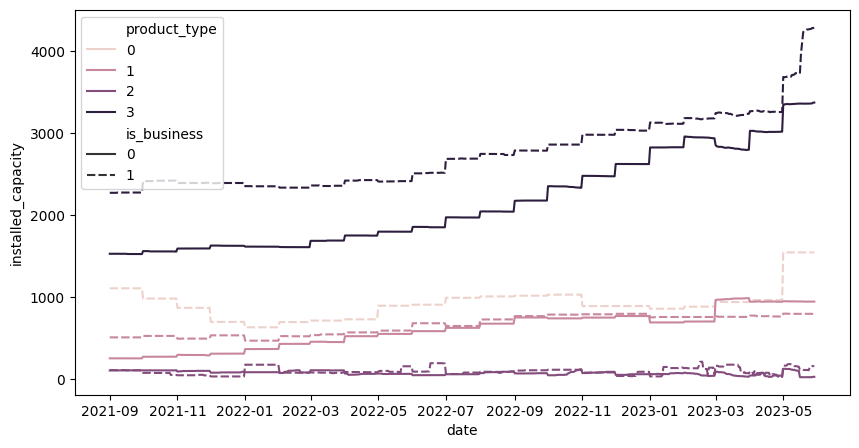

In [69]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='product_type', style='is_business', errorbar=None)

Most of the capacity is in product type 3 and for buisnesses. Product 0 appears to be available to buisnesses only.

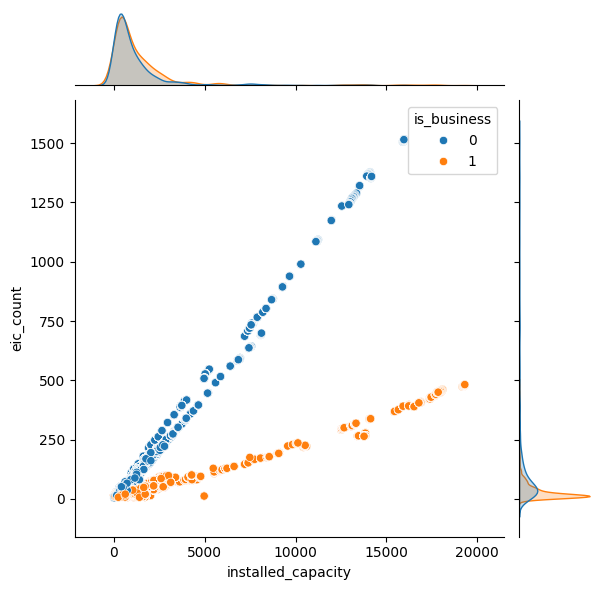

In [76]:
sns.jointplot(data=data.clients, x='installed_capacity', y='eic_count', hue='is_business')

At the very large capacities / eic counts, they correlate very well, with a slope that depends on whether the location is a buisness. However, this represents a very small fraction of the data.

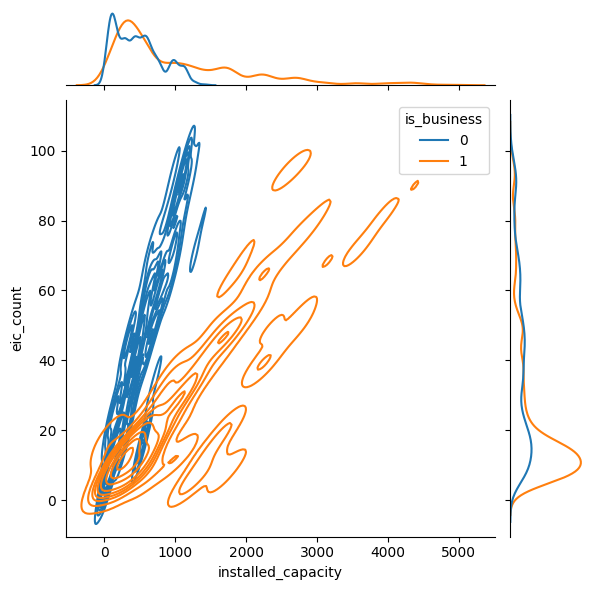

In [97]:
sns.jointplot(data=data.clients[ (data.clients.eic_count < 100) ],
              x='installed_capacity', y='eic_count', hue='is_business', kind='kde')

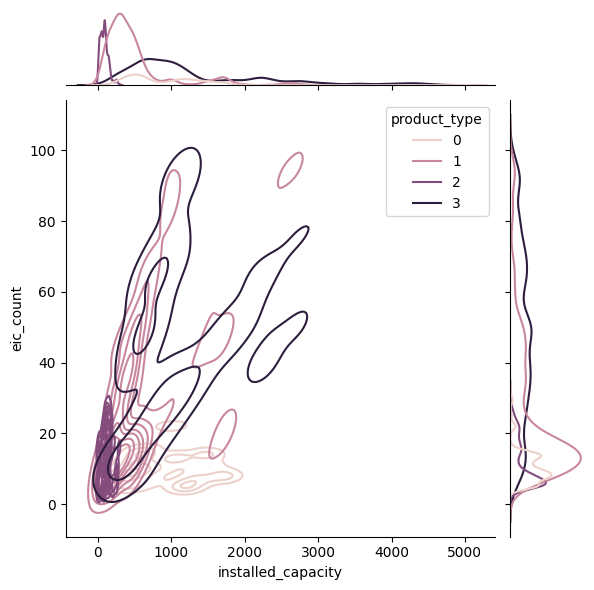

In [95]:
sns.jointplot(data=data.clients[ (data.clients.eic_count < 100) ],
              x='installed_capacity', y='eic_count', hue='product_type', kind='kde')

This relationship seems to hold down into the bulk of the data, and  can resolve product types as well.

<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

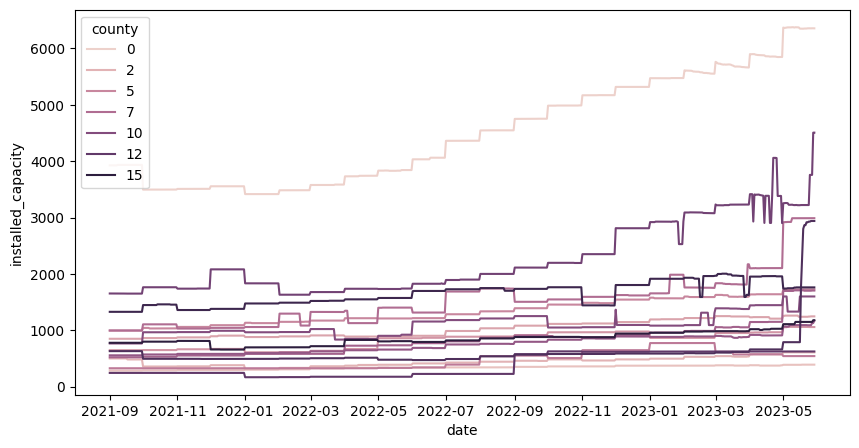

In [139]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='county', errorbar=None)

Hard to read much out of the county level data. Except that we know that one county dominates the others.